In [1]:
import locusPocus

import numpy as np 
import pandas as pd
%matplotlib inline
import sys
import seaborn as sns
%matplotlib inline
import contextily as cx
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd

import cartopy.crs as ccrs
import cartopy.feature as cfeature

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

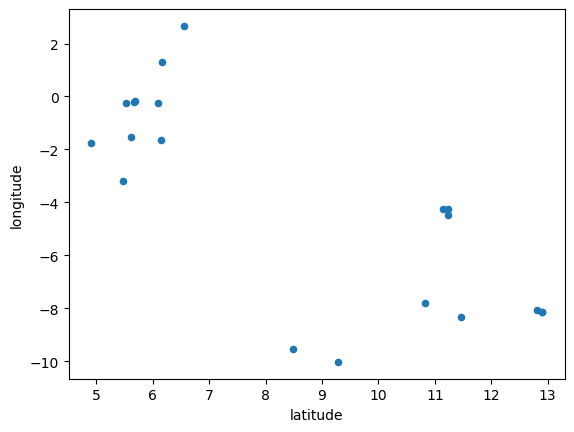

In [2]:
freqs = pd.read_csv("../../results/haplotype_clusters_locations_frequencies.tsv", sep="\t")
freqs = freqs.query("country != 'Tanzania'")
freqs = freqs.drop_duplicates()
freqs.plot(x='latitude', y='longitude', kind='scatter')

In [3]:
freqs.head(3)

,country,location,latitude,longitude,C1,C2,C3,C4,C5,C6,WT,n
0,Benin,Avrankou,6.550,2.667,0.0,0.000000,0.000000,0.0,0.161111,0.105556,0.733333,180
1,Burkina Faso,Bana Village,11.233,-4.472,0.0,0.023560,0.136126,0.0,0.000000,0.015707,0.824607,764
2,Burkina Faso,Pala,11.151,-4.235,0.0,0.065789,0.348684,0.0,0.000000,0.000000,0.585526,304


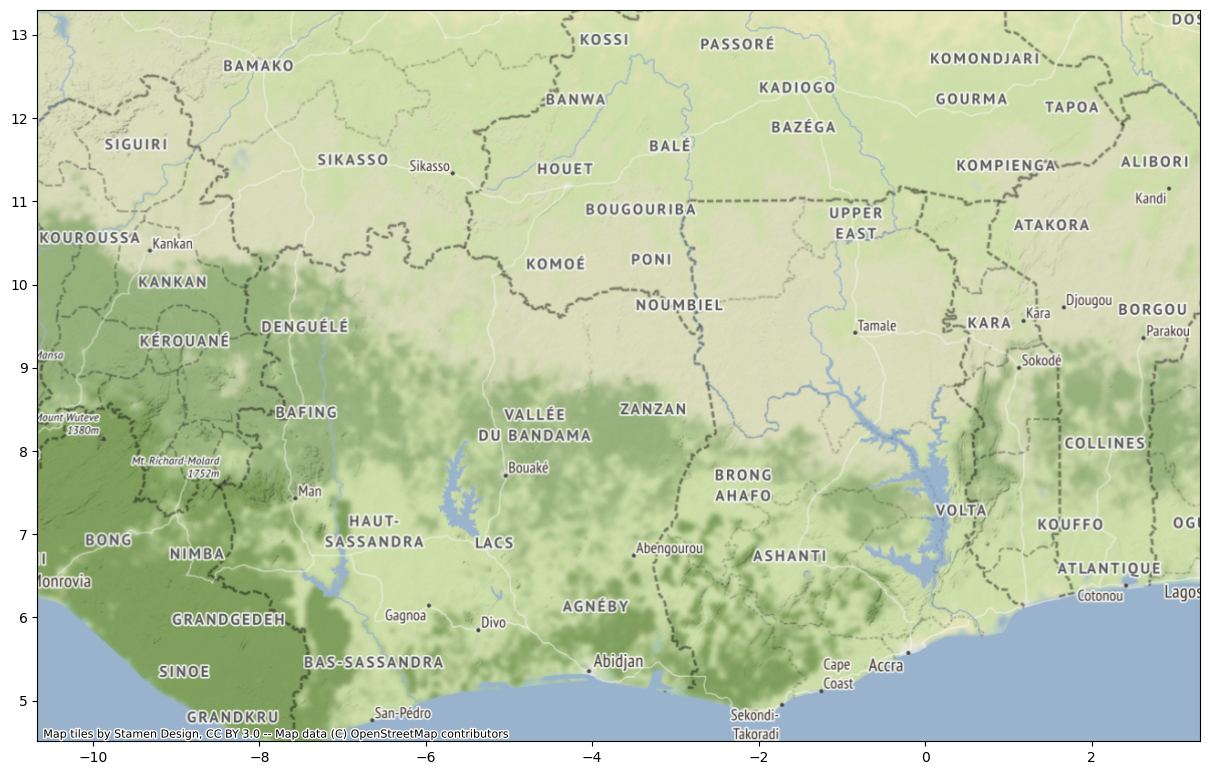

In [4]:
# Sample positions
freqMap = gpd.GeoDataFrame(
    freqs, geometry=gpd.points_from_xy(freqs.longitude, freqs.latitude, crs="EPSG:4326"))

ax = freqMap.plot(figsize=(15, 13), alpha=0)
cx.add_basemap(ax, crs="EPSG:4326")

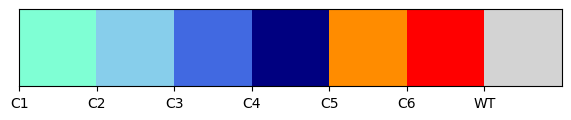

In [5]:
clusters_df = locusPocus.clusters_df

palette= clusters_df['palette'].to_list()
hap_labels = clusters_df['Haplotype cluster']

sns.palplot(palette)
plt.gca().set_xticklabels(hap_labels);

In [6]:
# for legend
f_colors = {l: c for l, c in zip(hap_labels, palette)}
f_colors

{'C1': 'aquamarine',
 'C2': 'skyblue',
 'C3': 'royalblue',
 'C4': 'navy',
 'C5': 'darkorange',
 'C6': 'red',
 'WT': 'lightgray'}

In [7]:
import cartopy

In [8]:
freqMap = freqMap.query("n > 5")

In [9]:
freqMap.location.unique()

array(['Avrankou', 'Bana Village', 'Pala', 'Souroukoudinga', 'Aboisso',
       'Koforidua', 'Korle-Bu', 'Madina_North', 'Madina_West', 'Obuasi',
       'Takoradi', 'Twifo Praso', 'Koraboh', 'Koundara', 'Kababougou',
       'Ouassorola', 'Takan', 'Tieneguebougou', 'Toumani Oulena',
       'Baguida'], dtype=object)

In [21]:
freqMap['location'] = freqMap['location'].str.replace("_", " ")

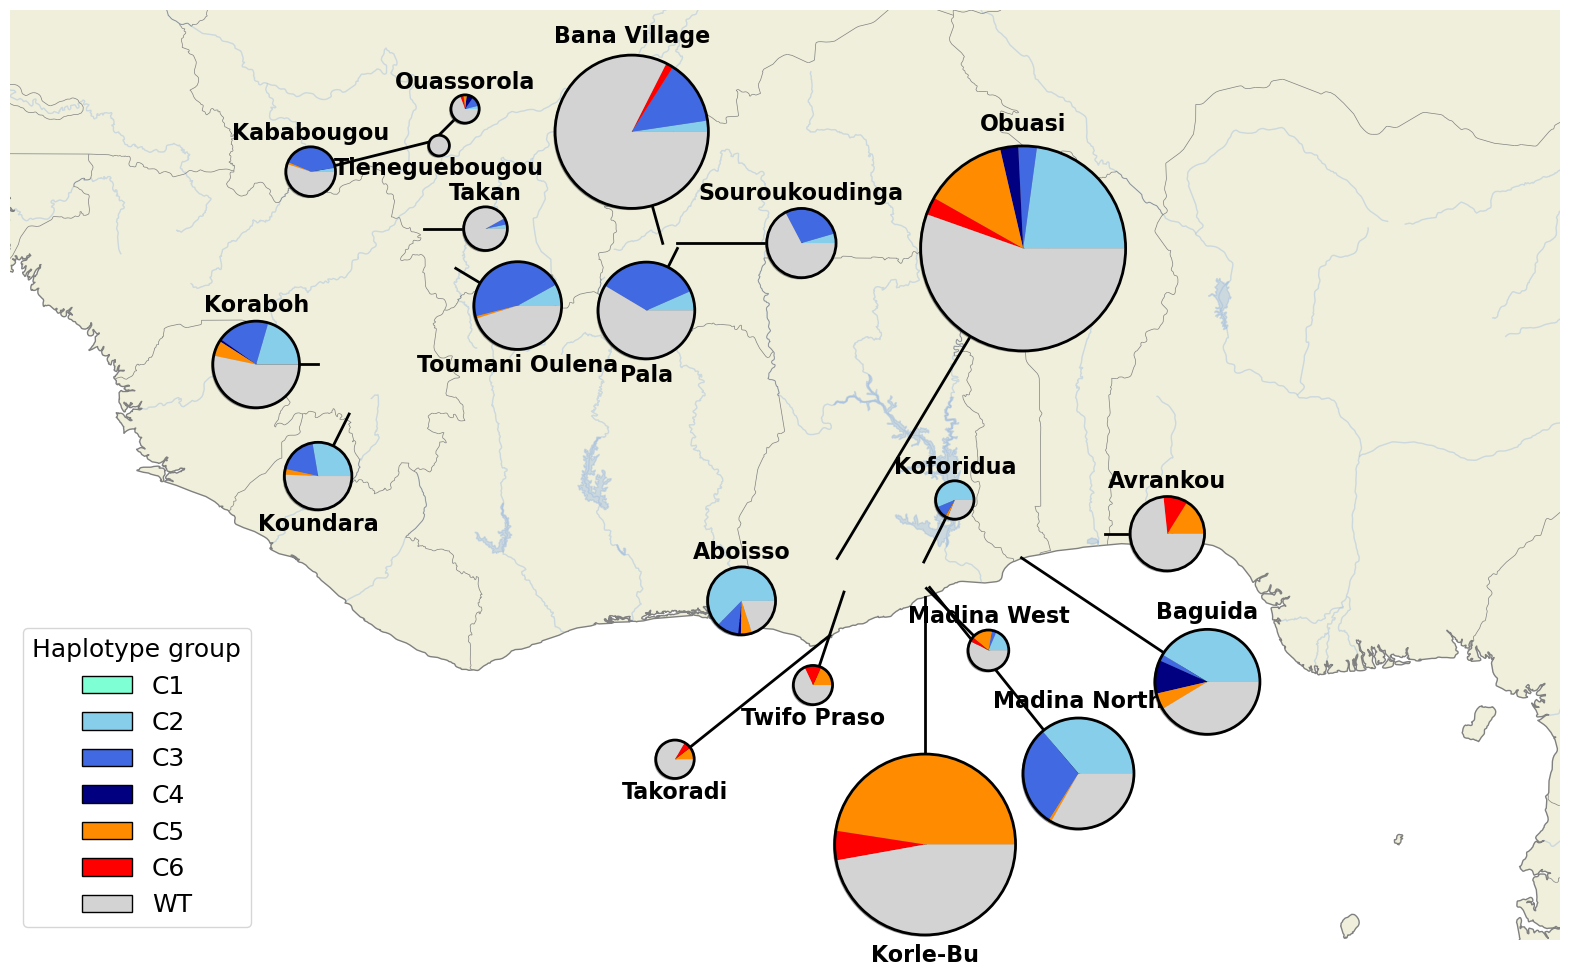

In [23]:
['Avrankou',
 'Bana Village',
 'Pala',
 'Souroukoudinga',
 'Aboisso',
 'Koforidua',
 'Korle-Bu',
 'Madina North',
 'Madina West',
 'Obuasi',
 'Takoradi',
 'Twifo Praso',
 'Koraboh',
 'Koundara',
 'Kababougou',
 'Ouassorola',
 'Takan',
 'Tieneguebougou',
 'Toumani Oulena',
 'Baguida']

#                                                   #madina
freqMap['offset_lat'] = [1, -0.5, -0.5, 2, 0, 0.5,     0,    2.4, 1, 3,  -2.5, -0.5, -1, -0.5, -2, 0.5,  1,   0,  1,   3]
freqMap['offset_lon'] = [0, 1.8,  -1,   0,   0, 1,    -4,   -3, -1,   5,  -2, -1.5, 0,  -1,    -0.5, 0.5, 0,   0,  -0.6, -2]
freqMap['label'] = ["bottom", "bottom", "top", "bottom", "bottom", "bottom", "top", "bottom", "bottom", "bottom", "top", "top", "bottom"
                    , "top", "bottom", "bottom", "bottom", "top", "top", "bottom"]

subplot_kw = dict(projection=ccrs.PlateCarree())
# figsize here is the entire figure size in inches, reduced later by bbox_inches
# This dpi setting affects the display size of the figure in the notebook
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw=subplot_kw)
ax.add_feature(cfeature.LAND, linewidth=1, zorder=1, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=2, edgecolor='gray')
ax.add_feature(cfeature.LAKES, alpha=0.4)
ax.add_feature(cfeature.RIVERS, alpha=0.4)


pie_scale_factor=0.002

for _, row in freqMap.iterrows():
    ratios = np.asarray([row[k] for k in hap_labels])
    ratios = np.append(ratios, 1 - np.sum(ratios))

    # wedgeprops is used here just to pass the zorder command
    centre = (row.geometry.x + row.offset_lat, row.geometry.y + row.offset_lon)
    radius=np.sqrt(row.n * pie_scale_factor)

    ax.add_patch(plt.Circle(xy=centre, radius=radius, facecolor='none', edgecolor='k', zorder=8, lw=2))
    ax.pie(ratios, wedgeprops=dict(zorder=7, linewidth=0), colors=palette, center=centre, radius=radius, shadow=True)

    lbl = row['location']
    if row.label == 'bottom':
        ax.text(centre[0], centre[1] + (radius + (0.1 * radius)), lbl, ha='center', va='bottom', fontsize=16, fontweight='bold', bbox=dict(edgecolor='w', facecolor='w', pad=1, alpha=0, ), zorder=6)
    if row.label == 'top':
        ax.text(centre[0], centre[1] - (radius + (0.1 * radius)), lbl, ha='center', va='top', fontsize=16, fontweight='bold', bbox=dict(edgecolor='w', facecolor='w', pad=1, alpha=0, ), zorder=6)

    if row.offset_lat != 0 or row.offset_lon != 0:
        ax.plot([row.geometry.x, row.geometry.x + row.offset_lat],[row.geometry.y, row.geometry.y + row.offset_lon], 'k-', lw=2, zorder=5)
      
    
#cover tiny island
#plt.plot([-15, -5],[-5, -30], 'w', lw=20, zorder=2)
ax.set_extent([-15, 10, 0, 15], crs=ccrs.PlateCarree())

handles = [matplotlib.patches.Patch(facecolor=f_colors[k], edgecolor='k', label=k) for k in hap_labels]
leg = ax.legend(handles=handles, bbox_to_anchor=(0, 0), loc='lower left', ncol=1, title="Haplotype group", title_fontsize=18, prop={'size': 18}, frameon=True, fancybox=True)    


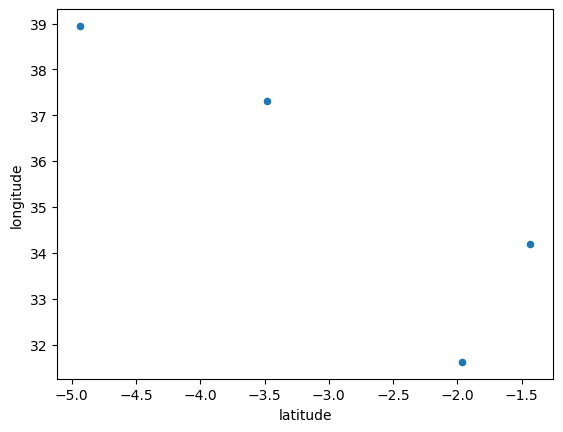

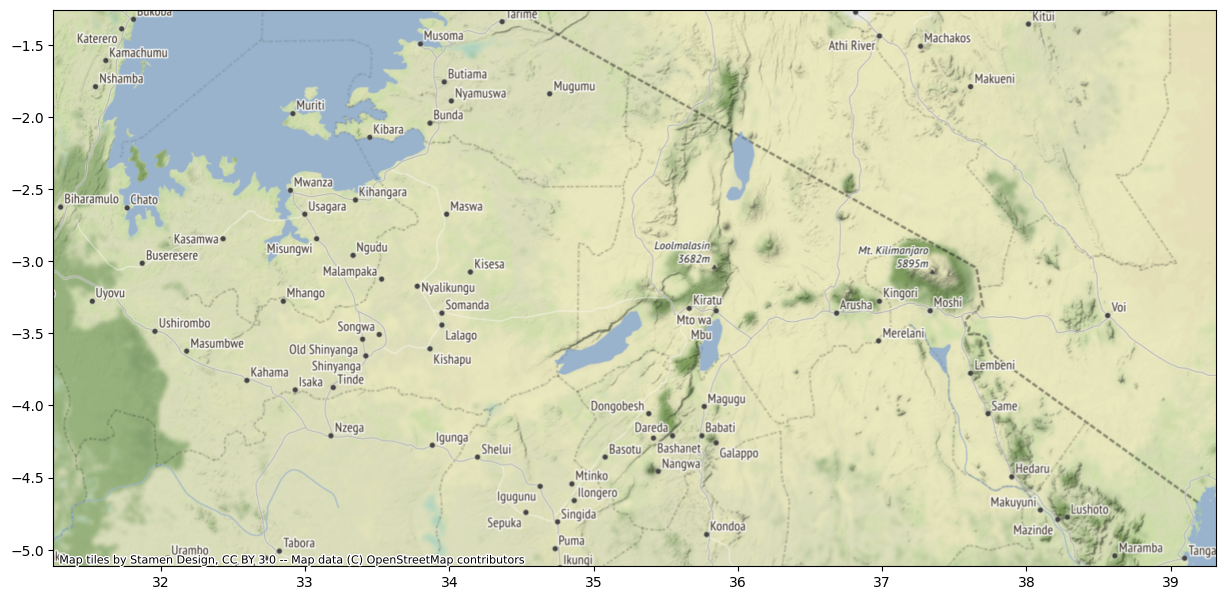

In [24]:
freqs = pd.read_csv("../../results/haplotype_clusters_locations_frequencies.tsv", sep="\t")
freqs = freqs.query("country == 'Tanzania'")
freqs = freqs.drop_duplicates()
freqs.plot(x='latitude', y='longitude', kind='scatter')

# Sample positions
freqMap = gpd.GeoDataFrame(
    freqs, geometry=gpd.points_from_xy(freqs.longitude, freqs.latitude, crs="EPSG:4326"))

ax = freqMap.plot(figsize=(15, 13), alpha=0)
cx.add_basemap(ax, crs="EPSG:4326")

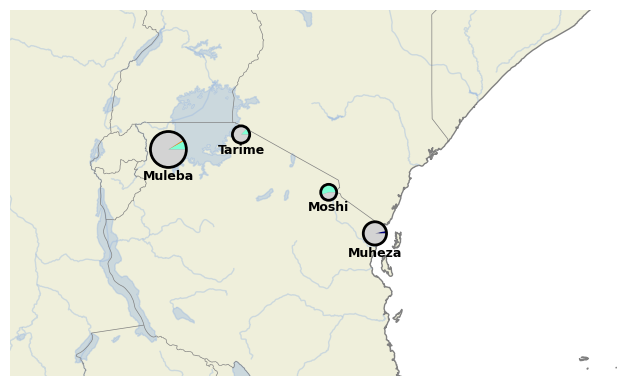

In [35]:
#                                                   #madina
freqMap['offset_lat'] = [0, 0, 0, 0]  
freqMap['offset_lon'] = [0, 0, 0, 0]
freqMap['label'] = ["top", "top", "top", "top"]

subplot_kw = dict(projection=ccrs.PlateCarree())
# figsize here is the entire figure size in inches, reduced later by bbox_inches
# This dpi setting affects the display size of the figure in the notebook
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=subplot_kw)
ax.add_feature(cfeature.LAND, linewidth=1, zorder=1, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linewidth=0.5, zorder=2, edgecolor='gray')
ax.add_feature(cfeature.LAKES, alpha=0.4)
ax.add_feature(cfeature.RIVERS, alpha=0.4)


pie_scale_factor=0.001

for _, row in freqMap.iterrows():
    ratios = np.asarray([row[k] for k in hap_labels])
    ratios = np.append(ratios, 1 - np.sum(ratios))

    # wedgeprops is used here just to pass the zorder command
    centre = (row.geometry.x + row.offset_lat, row.geometry.y + row.offset_lon)
    radius=np.sqrt(row.n * pie_scale_factor)

    ax.add_patch(plt.Circle(xy=centre, radius=radius, facecolor='none', edgecolor='k', zorder=8, lw=2))
    ax.pie(ratios, wedgeprops=dict(zorder=7, linewidth=0), colors=palette, center=centre, radius=radius, shadow=True)

    lbl = row['location']
    if row.label == 'bottom':
        ax.text(centre[0], centre[1] + (radius + (0.1 * radius)), lbl, ha='center', va='bottom', fontsize=9, fontweight='bold', bbox=dict(edgecolor='w', facecolor='w', pad=1, alpha=0, ), zorder=6)
    if row.label == 'top':
        ax.text(centre[0], centre[1] - (radius + (0.1 * radius)), lbl, ha='center', va='top', fontsize=9, fontweight='bold', bbox=dict(edgecolor='w', facecolor='w', pad=1, alpha=0, ), zorder=6)

    if row.offset_lat != 0 or row.offset_lon != 0:
        ax.plot([row.geometry.x, row.geometry.x + row.offset_lat],[row.geometry.y, row.geometry.y + row.offset_lon], 'k-', lw=2, zorder=5)
    
    
#cover tiny island
#plt.plot([-15, -5],[-5, -30], 'w', lw=20, zorder=2)
ax.set_extent([26, 48, 3, -10], crs=ccrs.PlateCarree())

# handles = [matplotlib.patches.Patch(facecolor=f_colors[k], edgecolor='k', label=k) for k in hap_labels]
# leg = ax.legend(handles=handles, bbox_to_anchor=(0, 0), loc='lower left', ncol=1, title="Haplotype group", title_fontsize=11, prop={'size': 11}, frameon=True, fancybox=True)    
